In [ ]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load the required packages
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [ ]:
# Specify the hyper-parameters
BATCH_SIZE = 1
IMAGE_SIZE = 224
EPOCHS=50
CHANNELS=3

In [ ]:
# Load the lung cancer images dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Final Project/The IQ-OTHNCCD lung cancer dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1097 files belonging to 3 classes.


In [ ]:
# The names of the classes (labels)
class_names = dataset.class_names
class_names

['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
# Display the shape of the dataset
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[0])
  print(label_batch.numpy())

(1, 224, 224, 3)
tf.Tensor(
[[[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 ...

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]], shape=(224, 224, 3), dtype=float32)
[1]


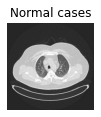

In [ ]:
# An image example is shown below:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# The get_dataset_partitions_tf function divides the original dataset into three parts: training set, validation set, and testing set
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

# Partition the lung cancer images dataset:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# Resize the dataset
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Augment the dataset
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Specify the input shape and number of classes (labels)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Part I: ResNet101 model without Curriculum Learning

In [ ]:
# Create ResNet101 structure
ResNet101 = tf.keras.applications.resnet.ResNet101(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=n_classes,
)

ResNet101.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Display the architecture of ResNet101
ResNet101.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
# Train the ResNet101 model with our training set using 50 epochs
history = ResNet101.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
877/877 [==============================] - 89s 57ms/step - loss: 1.3145 - accuracy: 0.4493 - val_loss: 1.8327 - val_accuracy: 0.3394
Epoch 2/50
877/877 [==============================] - 47s 54ms/step - loss: 1.0967 - accuracy: 0.4743 - val_loss: 1.3966 - val_accuracy: 0.4404
Epoch 3/50
877/877 [==============================] - 47s 54ms/step - loss: 1.0847 - accuracy: 0.4949 - val_loss: 1.2531 - val_accuracy: 0.3945
Epoch 4/50
877/877 [==============================] - 47s 54ms/step - loss: 1.0505 - accuracy: 0.5051 - val_loss: 9.3567 - val_accuracy: 0.3486
Epoch 5/50
877/877 [==============================] - 47s 54ms/step - loss: 1.0506 - accuracy: 0.4846 - val_loss: 6.8433 - val_accuracy: 0.4679
Epoch 6/50
877/877 [==============================] - 47s 54ms/step - loss: 1.0526 - accuracy: 0.4641 - val_loss: 2.8906 - val_accuracy: 0.3486
Epoch 7/50
877/877 [==============================] - 47s 54ms/step - loss: 1.0204 - accuracy: 0.4949 - val_loss: 1.6846 - val_accuracy:

In [ ]:
# Calculate the final testing accuracy with the testing set
ResNet101.evaluate(test_ds)

111/111 [==============================] - 2s 15ms/step - loss: 2.5874 - accuracy: 0.5856


[2.587374687194824, 0.5855855941772461]

# Part II: ResNet101 model with Curriculum Learning

Curriculum Learning is essentially a data-preprocessing technique to improve the final accuracy of the model. In our case, we first used the pre-trained MobileNet model to generate Sparse Categorical Cross Entropy on the training set. We then regarded the losses as the difficulty scores for the training examples. The higher the loss for a particular example, the more difficult the example is. Then, we sorted the training examples from the easiest to the hardest based on the difficulty scores. The newly sorted training set is now ready to train the ResNet101 model.

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# Download the pre-trained MobileNet model
MobileNet = tf.keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Display the architecture of MobileNet
MobileNet.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
# Generate predictions on the training set
pred = MobileNet.predict(train_ds)

# Extract labels from the training set
labels = []
for exm in train_ds:
  labels.append(exm[1].numpy())
labels = np.array(labels).flatten()

877/877 [==============================] - 4s 3ms/step


In [ ]:
# Calculate Sparse Categorical Cross Entropy for each training examples
scce = tf.keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE)
difficulty = pd.DataFrame(scce(labels, pred).numpy(), columns = ["Difficulty"])

# Create training example order by their Sparse Categorical Cross Entropy ("Difficulty")
difficulty['index'] = range(len(difficulty))
difficulty = difficulty.sort_values(['Difficulty'], ascending=True)
difficulty

,Difficulty,index
533,6.764977,533
106,6.904140,106
324,6.937891,324
708,6.967781,708
786,7.000387,786
...,...,...
842,13.650282,842
152,13.729055,152
240,13.740128,240
63,14.165200,63


In [ ]:
# Sort the training examples by the specified order
order = np.array(difficulty["index"])
order = tf.data.Dataset.from_tensor_slices(order)

order = order.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
total_dataset = tf.data.Dataset.zip((train_ds, order))

new_data = []

for exm in total_dataset:
  new_data.append(exm)

new_data = pd.DataFrame(new_data, columns=["Samples", "Order"])
new_data = new_data.sort_values(by=['Order'], ascending=True)
new_data

,Samples,Order
563,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(0, shape=(), dtype=int64)"
53,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(1, shape=(), dtype=int64)"
374,(((tf.Tensor(\n[[40.890625 40.890625 40.890625...,"tf.Tensor(2, shape=(), dtype=int64)"
593,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(3, shape=(), dtype=int64)"
342,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(4, shape=(), dtype=int64)"
...,...,...
247,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(872, shape=(), dtype=int64)"
809,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(873, shape=(), dtype=int64)"
683,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(874, shape=(), dtype=int64)"
477,(((tf.Tensor(\n[[38. 38. 38. ...,"tf.Tensor(875, shape=(), dtype=int64)"


In [ ]:
# Create sorted training samples and their labels
new_data_features = []
new_data_labels = [] 

for i in range(len(new_data["Samples"])):
  new_data_features.append(new_data["Samples"][i][0])
  new_data_labels.append(new_data["Samples"][i][1])


new_data_features = np.array(new_data_features)
new_data_labels = np.array(new_data_labels)
new_data_features, new_data_labels

(array([[[[[38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.],
           ...,
           [38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.]],
 
          [[38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.],
           ...,
           [38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.]],
 
          [[38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.],
           ...,
           [38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.]],
 
          ...,
 
          [[38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.],
           ...,
           [38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.]],
 
          [[38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.],
           ...,
           [38., 38., 38.],
           [38., 38., 38.],
           [38., 38., 38.]],
 
          [[38., 38., 38.],
           [38., 38.

In [ ]:
# Create new train data with ascending difficulty order
new_train_data_features = tf.data.Dataset.from_tensor_slices(new_data_features)
new_train_data_labels = tf.data.Dataset.from_tensor_slices(new_data_labels)
new_train_data = tf.data.Dataset.zip((new_train_data_features, new_train_data_labels))
new_train_data

<ZipDataset element_spec=(TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

In [ ]:
# Convert the new training data to PrefetchDataset
new_train_data = new_train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
new_train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

In [ ]:
# Create a new ResNet101 structure for curriculum learning
new_ResNet101 = tf.keras.applications.resnet.ResNet101(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=n_classes,
)

new_ResNet101.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE),
    metrics=['accuracy']
)

# Display the architecture of ResNet101
new_ResNet101.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
# Train the new ResNet101 model
new_history = new_ResNet101.fit(
    new_train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
877/877 [==============================] - 58s 55ms/step - loss: 1.2595 - accuracy: 0.4618 - val_loss: 1.4883 - val_accuracy: 0.4679
Epoch 2/50
877/877 [==============================] - 46s 53ms/step - loss: 1.0611 - accuracy: 0.5165 - val_loss: 1.7528 - val_accuracy: 0.4679
Epoch 3/50
877/877 [==============================] - 46s 53ms/step - loss: 1.0256 - accuracy: 0.5325 - val_loss: 1.5023 - val_accuracy: 0.4679
Epoch 4/50
877/877 [==============================] - 46s 53ms/step - loss: 1.0870 - accuracy: 0.5108 - val_loss: 1.3499 - val_accuracy: 0.4679
Epoch 5/50
877/877 [==============================] - 46s 53ms/step - loss: 1.0768 - accuracy: 0.4595 - val_loss: 1.3173 - val_accuracy: 0.4679
Epoch 6/50
877/877 [==============================] - 46s 53ms/step - loss: 1.0441 - accuracy: 0.4869 - val_loss: 3.2044 - val_accuracy: 0.4679
Epoch 7/50
877/877 [==============================] - 46s 53ms/step - loss: 1.0033 - accuracy: 0.5188 - val_loss: 1.1800 - val_accuracy:

In [ ]:
# Calculate the final testing accuracy with the testing set
new_ResNet101.evaluate(test_ds)

111/111 [==============================] - 2s 15ms/step - loss: 0.4652 - accuracy: 0.8739


[0.4652232527732849, 0.8738738894462585]

# Part III: Comparing the Results

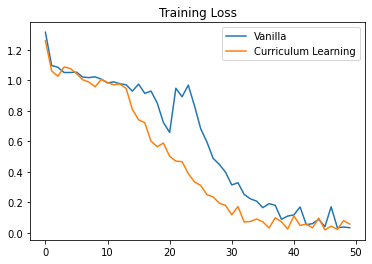

In [ ]:
# Plot the training losses with and without curriculum learning
plt.plot(history.history['loss'])
plt.plot(new_history.history['loss'])
plt.title("Training Loss")
plt.legend(['Vanilla', 'Curriculum Learning'], loc='upper right')

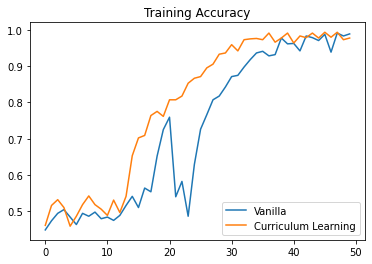

In [ ]:
# Plot the training accuracy with and without curriculum learning
plt.plot(history.history['accuracy'])
plt.plot(new_history.history['accuracy'])
plt.title("Training Accuracy")
plt.legend(['Vanilla', 'Curriculum Learning'], loc='lower right')

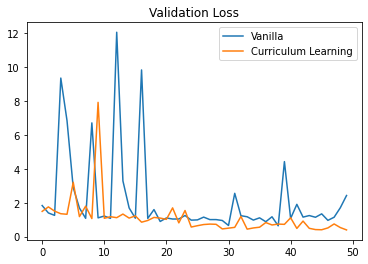

In [ ]:
# Plot the validation losses with and without curriculum learning
plt.plot(history.history['val_loss'])
plt.plot(new_history.history['val_loss'])
plt.title("Validation Loss")
plt.legend(['Vanilla', 'Curriculum Learning'], loc='upper right')

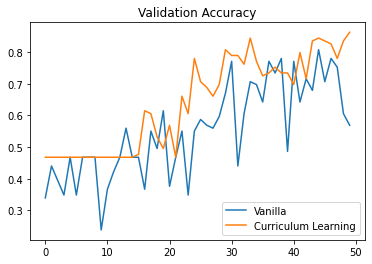

In [ ]:
# Plot the validation accuracy with and without curriculum learning
plt.plot(history.history['val_accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title("Validation Accuracy")
plt.legend(['Vanilla', 'Curriculum Learning'], loc='lower right')

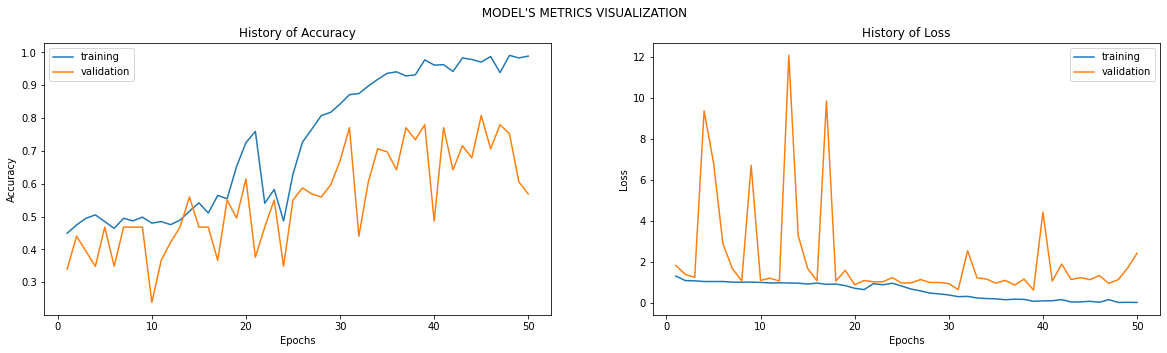

In [ ]:
# Plot the losses and accuracies for ResNet101 without curriculum learning
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
              )


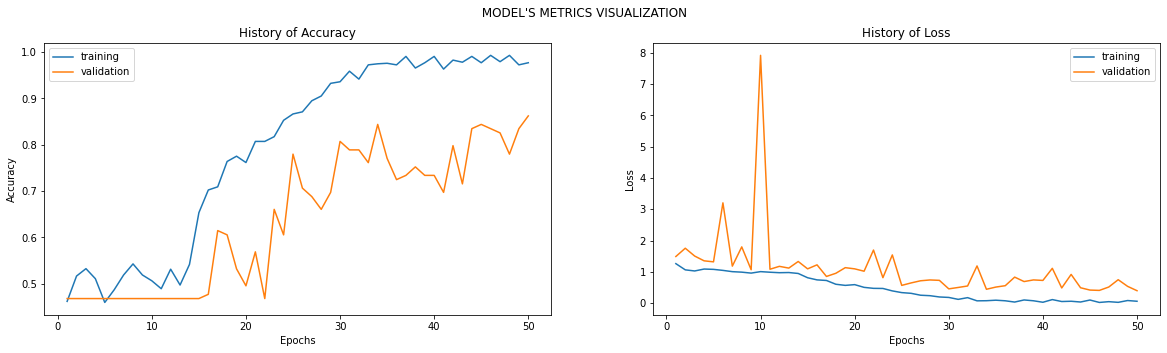

In [ ]:
# Plot the losses and accuracies for ResNet101 with curriculum learning
Train_Val_Plot(new_history.history['accuracy'],new_history.history['val_accuracy'],
               new_history.history['loss'],new_history.history['val_loss'],
              )